In [1]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import matplotlib.colors as mcolors

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA

# from pmdarima import auto_arima

from typing import List
from typing_extensions import Annotated

import requests
from io import BytesIO

In [2]:
# Data Reading

#df = pd.read_excel("../data/Registro Público de Emissões.xlsx")

URL = "https://raw.githubusercontent.com/thiagoneye/project-ccus_analysis/main/data/Registro%20P%C3%BAblico%20de%20Emiss%C3%B5es.xlsx"
response = requests.get(URL)
df = pd.read_excel(BytesIO(response.content))

# Data Processing

df = df[df["Escopo"] == "Total"]
df.drop(columns=["Setor da Indústria", "Escopo"], inplace=True)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:].reset_index()
df = df.rename(columns={"index": "Years"})

# Company Names

list_of_companies = np.array(["ArcelorMittal", "Votorantim", "Ternium", "Suzano", "CBA", "Intercement"])

# Dataframe Cleaning

for col in list_of_companies:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(float)

df.iloc[:, 1:] = df.iloc[:, 1:]/1e6

common_year = 2017
df_filtered = df[df.Years >= common_year]

display(df.head())
display(df.info())

Empresa,Years,Suzano,CSN,Intercement,Ternium,Votorantim,ArcelorMittal,CBA,ISA Energia
0,2008,1.071559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,0.734910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1.050929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1.369238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,1.355714,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Years          16 non-null     int64  
 1   Suzano         16 non-null     float64
 2   CSN            11 non-null     object 
 3   Intercement    11 non-null     float64
 4   Ternium        11 non-null     float64
 5   Votorantim     9 non-null      float64
 6   ArcelorMittal  7 non-null      float64
 7   CBA            7 non-null      float64
 8   ISA Energia    7 non-null      object 
dtypes: float64(6), int64(1), object(2)
memory usage: 1.3+ KB


None

In [3]:
# Auxiliaries Function


def applies_power_law(X, y, X_pred):
    X_last = X[-1]
    y_last = y[-1]
    y_pred = y_last * np.exp(np.log(0.91) * (X_pred - X_last) / (2030 - X_last))
    return y_pred


def applies_constant_line(y, X_pred):
    y_last = y[-1]
    y_pred = y_last * np.ones(len(X_pred))
    return y_pred


def get_values(df, company_name):
    X_plot = df.Years.values
    y_plot = df.loc[:, company_name].values
    X_plot = X_plot[~np.isnan(y_plot)]
    y_plot = y_plot[~np.isnan(y_plot)]

    return X_plot, y_plot


def set_weights(data, w: list, commom_range_delimiter=5):
    """Set weights for weighted regression."""

    weights = np.ones(len(data))

    weights[:commom_range_delimiter] = w[0]  # past window weight
    weights[commom_range_delimiter:] = w[1]  # common window weight

    return weights


def generate_weight_pairs_matrix(weight_a, weight_b, n):
    """Generate matrix with weight lists [wa, wb], such that wa + wb = 1 for tests."""

    # Matrix Columns
    col2 = np.linspace(weight_a, weight_b, n)
    col1 = 1 - col2

    # Matrix
    weight_pairs = np.column_stack((col1, col2))

    return weight_pairs


def fit_model(
    X,
    y,
    model: str,
    weights: Annotated[List[float], "List of past- and common-windou weights [wp, wc]"],
    commom_range_delimiter,
):
    """Select models for weighted regression."""

    # Weights
    weights = set_weights(y, weights, commom_range_delimiter)

    # Reshape Input for 2D
    X = X.reshape(-1, 1)

    if model == "poly":
        M = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        M.fit(X, y, linearregression__sample_weight=weights)

    elif model == "svr-rbf":
        M = make_pipeline(StandardScaler(), SVR(kernel="rbf"))
        M = SVR(kernel="rbf")
        M.fit(X, y, sample_weight=weights)

    elif model == "svr-poly":
        M = SVR(kernel="poly")
        M.fit(X, y, sample_weight=weights)

    elif model == "rf":
        M = RandomForestRegressor(n_estimators=100)
        M.fit(X, y, sample_weight=weights)

    return M

import matplotlib.pyplot as plt

def add_axvspan_annotation(ax, ta, tb, y_baseline=None):
    """
    Adiciona um axvspan e uma anotação com texto baseado em tb.

    Parâmetros:
    ax: Objeto de eixo do Matplotlib.
    ta: Início do axvspan.
    tb: Fim do axvspan.
    y_baseline: Altura da baseline da anotação (opcional, padrão é o meio do eixo y).

    Retorna:
    None (adiciona axvspan e anotação ao eixo).
    """

    if ta == 2023:
        text = "future domain"
        ax.axvspan(ta, tb, alpha=0.3, color='#ebfbee')
    elif ta == 2017:
        text = "common domain"
        ax.axvspan(ta, tb, alpha=0.3, color='#e7f5ff')
    else:
        text = "past domain"
        ax.axvspan(ta, tb, alpha=0.3, color='#e9ecef')

    x_center = (ta + tb) / 2

    if y_baseline is None:
        y_min, y_max = ax.get_ylim()
        y_baseline = (y_min + y_max) / 2

    ax.annotate(
        text,
        xy=(x_center, y_baseline),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor="lightgray", alpha=0.8)
    )

def get_ylim(y_min, y_max):
    delta = 0.25*(y_max - y_min)
    return (y_min - delta, y_max + delta)


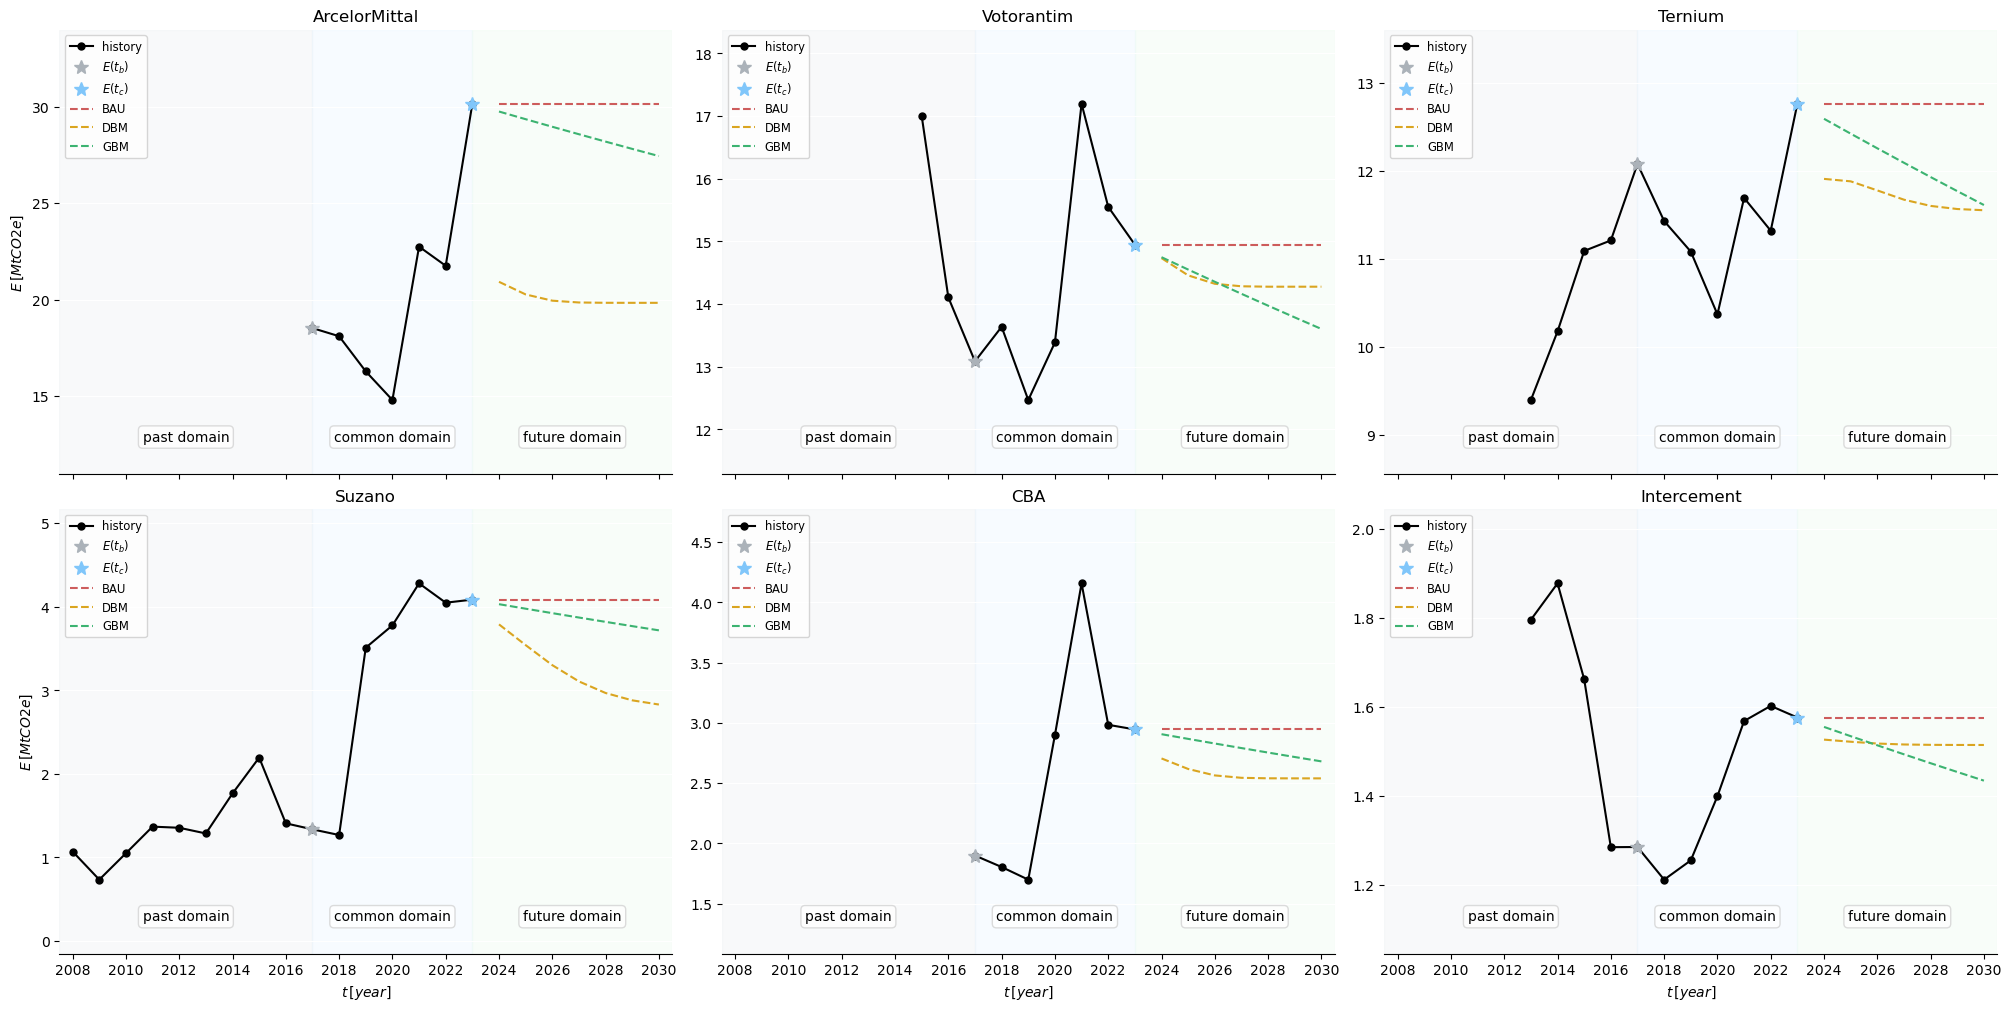

In [6]:
# Execution

# Set Span Limits

past_range = [2007.5, 2017]
commom_range = [2017, 2023]
future_range = [2023, 2030.5]

# Years for Prediction

X_pred = np.array(range(2024, 2031))

# Training Parameters (SVR)

weights = [0.1, 0.9]
windows = 2

# Preparing Variables for Data Export

output = dict()
output["Years"] = X_pred.tolist()

# Start Plot

fig, axs = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True, sharex=True)
axs = axs.flatten()

colors = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
}

for company_id, company_name in enumerate(list_of_companies):
    # Data Processing for Training
    X_train, y_train = get_values(df, company_name)
    X_filtered, y_filtered = get_values(df_filtered, company_name)
    commom_range_delimiter = np.where(X_train == common_year)[0][0]

    # Plot (Past and Commom)
    ax = axs[company_id]
    ax.plot(X_train, y_train, "-ok", ms=5, label="history")
    ax.plot(X_filtered[0], y_filtered[0], "*", color="#abb2b9", ms=10, label="$E(t_b)$")
    ax.plot(X_train[-1], y_train[-1], "*", color="#80c6fa", ms=10, label="$E(t_c)$")

    # BAU
    y_pred = applies_constant_line(y_train, X_pred)
    output[f"{company_name} - BAU"] = y_pred.tolist()

    ax.plot(X_pred, y_pred, "--", color=colors["BAU"], label="BAU")

    # DBM
    y_pred = fit_model(
        X_train, y_train, "svr-rbf", weights, commom_range_delimiter
    ).predict(X_pred.reshape(-1, 1))
    y_pred[y_pred < 0] = 0
    output[f"{company_name} - DBM"] = y_pred.tolist()

    ax.plot(X_pred, y_pred, "--", color=colors["DBM"], label="DBM")

    # GBM
    y_pred = applies_power_law(X_filtered, y_filtered, X_pred)
    output[f"{company_name} - GBM"] = y_pred.tolist()

    ax.plot(X_pred, y_pred, "--", color=colors["GBM"], label="GBM")

    # Configure Plot
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.set_xlim([2007.5, 2030.5])

    y_min, y_max = min(y_train), max(y_train)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)

    ax.set_ylim([y_min_lim, y_max_lim])

    add_axvspan_annotation(ax, past_range[0], past_range[1], y_baseline=np.mean([y_min, y_min_lim]))
    add_axvspan_annotation(ax, commom_range[0], commom_range[1], y_baseline=np.mean([y_min, y_min_lim]))
    add_axvspan_annotation(ax, future_range[0], future_range[1], y_baseline=np.mean([y_min, y_min_lim]))

    ax.grid(color='w', axis="y")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(loc="upper left", fontsize="small")
    ax.set_title(f"{company_name}")

    if company_id in [0, 3]:
        ax.set_ylabel("$E \\, [MtCO2e]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

fig.savefig(f"../img/Forecast.png")

In [5]:
# Export Values

output = pd.DataFrame(output)
# output.to_csv("../data/Forecast (MtCO2e).csv")
# output.to_excel("../data/Forecast (MtCO2e).xlsx")
